Compare multilevel perceptrons (MLPs) on the spiral classification problem, where data is generated from several clusters with varying spiral radii.

In [ ]:
# Run to select GPU #1 and limit memory usage to 30%
# from armed.tfutils import set_gpu
# set_gpu(1, 0.3)

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import stats
from sklearn.model_selection import StratifiedKFold

from spirals import make_spiral_random_radius, make_spiral_random_radius_confounder, plot_clusters, make_spiral_true_boundary
from armed.models.mlp_classifiers import BaseMLP, ClusterCovariateMLP, DomainAdversarialMLP, MixedEffectsMLPNonlinearSlope
from armed.models.metalearning import mldg
from armed.misc import expand_results_path, make_random_onehot

Define output directory path.

In [3]:
strOutputDir = expand_results_path('spirals_20220201/random_radii', make=True)

Spiral generation parameters. 
* clusters: Number of clusters 
* false_negatives: True draws the random radii from a distribution centered at zero, such that half the clusters have flipped spirals. This increases problem difficulty by obscuring the predictiveness of the features. False centers the distribution at 1. 
* confound_sd: If simulating confounded_vars, sets the strength of the confounding factor.
* radius_sd: Inter-cluster variance of random radii
* degrees: Spiral arclength in degrees
* confounded_vars: Number of confounded variables to add
* noise: s.d. of added Gaussian noise
* random_seed

In [4]:
dictSpiralParams = {'clusters': 10, 
                    'false_negatives': False, 
                    'confound_sd': 0.,
                    'radius_sd': 0.3,
                    'degrees': 360,
                    'confounded_vars': 0,
                    'noise': 0.1,
                    'random_seed': 48}

Create and visualize dataset

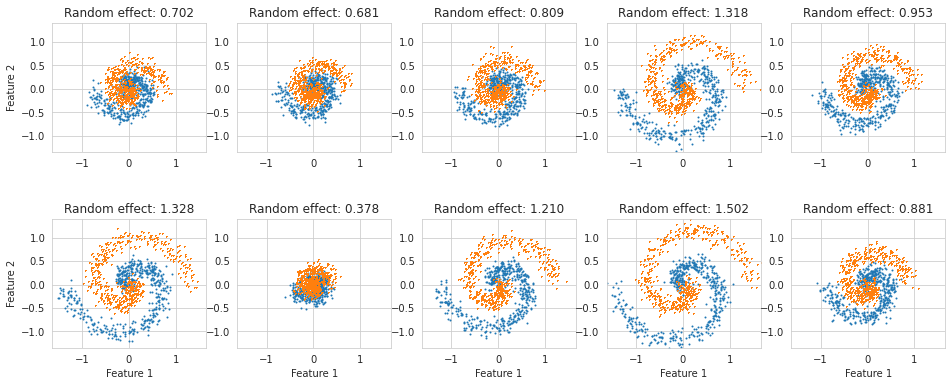

In [5]:
# Create dataset
np.random.seed(dictSpiralParams['random_seed'])
if dictSpiralParams['confound_sd'] > 0:
    arrX, arrZ, arrY, arrRadii, arrRatio = make_spiral_random_radius_confounder(dictSpiralParams['clusters'],
                                                                                mean_radius=0 if dictSpiralParams['false_negatives'] else 1,
                                                                                ratio_sd=dictSpiralParams['confound_sd'],
                                                                                radius_sd=dictSpiralParams['radius_sd'],
                                                                                degrees=dictSpiralParams['degrees'],
                                                                                confounders=dictSpiralParams['confounded_vars'],
                                                                                noise=dictSpiralParams['noise'])
else:    
    arrX, arrZ, arrY, arrRadii = make_spiral_random_radius(dictSpiralParams['clusters'], 
                                                        mean_radius=0 if dictSpiralParams['false_negatives'] else 1, 
                                                        inter_cluster_sd=dictSpiralParams['radius_sd'], 
                                                        degrees=dictSpiralParams['degrees'],
                                                        noise=dictSpiralParams['noise'])

figData, axData = plot_clusters(arrX, arrZ, arrY, arrRadii)
figData.savefig(os.path.join(strOutputDir, 'spirals_data.png'))
figData.savefig(os.path.join(strOutputDir, 'spirals_data.svg'))
figData.show()

# One-hot to binary labels
arrY = arrY[:, 1]

# Ensure float32
arrX = arrX.astype(np.float32)
arrY = arrY.astype(np.float32)
arrZ = arrZ.astype(np.float32)

# Use the class label and cluster membership in stratified k-fold partitioning later
arrStrata = [f'{y}_{z}' for y, z in zip(arrY, arrZ.argmax(axis=1))]
arrStrata = np.array(arrStrata)

In [6]:
# create informative names for the confounded probe features
lsFeatureNames = ['1', '2'] 
if dictSpiralParams['confounded_vars'] > 0:
    lsFeatureNames += [f'Probe {i+1}' for i in range(dictSpiralParams['confounded_vars'])]

In [7]:
def compute_grads(model, inputs):
    """Compute feature gradients/partial derivatives.

    Args:
        model: trained model
        inputs (array or tuple): model inputs

    Returns:
        pd.DataFrame: feature gradients
    """    

    if isinstance(inputs, tuple):
        x, z = inputs
        x = x.mean(axis=0).reshape((1, -1))
        # Use all zero design matrix, since for the ME-MLP we 
        # only want to measure the feature sensitivity of the 
        # fixed effects submodel.
        z = np.zeros((1, z.shape[1]), dtype=np.float32)
        
        with tf.GradientTape() as gt:
            tx = tf.constant(x)
            tz = tf.zeros_like(z)
            gt.watch(tx)
            gt.watch(tz)
            ty = model((tx, tz))
            
        dydx = gt.gradient(ty, tx)

    else:
        x = inputs
        x = x.mean(axis=0).reshape((1, -1))
        with tf.GradientTape() as gt:
            tx = tf.constant(x)
            gt.watch(tx)
            ty = model(tx)
            
        dydx = gt.gradient(ty, tx)

    dfGrads = pd.DataFrame(np.abs(dydx.numpy()), columns=lsFeatureNames)
    return pd.melt(dfGrads, var_name='Feature', value_name='Gradient')
    
def compute_random_slope_sd(model):
    """Compute the inter-cluster variances of the ME-MLP's learned random slopes.

    Args:
        model: trained model

    Returns:
        pd.DataFrame: s.d. for each feature
    """    
    arrRandomSlopePosterior = model.randomeffects.re_slope.weights[0].numpy()
    nClusters = dictSpiralParams['clusters']
    nFeatures = 2 + dictSpiralParams['confounded_vars']
    nWeights = nClusters * nFeatures
    arrRandomSlope = arrRandomSlopePosterior[:nWeights]
    arrRandomSlope = arrRandomSlope.reshape((nClusters, nFeatures))

    return pd.DataFrame({'Feature': lsFeatureNames, 'S.D.': arrRandomSlope.std(axis=0)})
    
def get_random_intercepts(model):
    """Get the learned random intercepts from the trained ME-MLP.

    Args:
        model: trained model

    Returns:
        pd.DataFrame: Cluster-specific random intercepts
    """    
    arrRandomIntPosterior = model.randomeffects.re_int.weights[0].numpy()
    nClusters = dictSpiralParams['clusters']
    arrRandomInt = arrRandomIntPosterior[:nClusters]
    
    return pd.DataFrame({'Cluster': range(nClusters), 'Random intercept': arrRandomInt})


def plot_percluster_decision_boundary(model, X, Y, Z, cluster_input=False, vmax=1.5, degrees=360, radii=None):
    """Plot decision boundaries learned per cluster. Currently only works with 2-class problems.

    Args:
        model (tf.keras.Model): trained model
        X (np.array): input
        Y (np.array): target
        Z (np.array): cluster membership matrix
        cluster_input (bool, optional): Whether model takes a cluster membership input. Defaults to False.
        vmax (float, optional): Extent of feature space to plot. Defaults to 1.5.
        degrees (int, optional): Spiral length (to plot true decision boundary). Defaults to 360.
        radii (array, optional): Cluster-specific radii (to plot true decision boundary). Defaults to None.

    Returns:
        figure, axes
    """    
    
    nClusters = Z.shape[1]
    nAxRows = int(np.ceil(nClusters / 5))
    fig, axes = plt.subplots(nAxRows, 5, figsize=(16, 3 * nAxRows), gridspec_kw={'hspace': 0.5})
    
    for iCluster in range(nClusters):
        ax = axes.flatten()[iCluster]
        
        arrXCluster = X[Z[:, iCluster]==1,]
        arrYCluster = Y[Z[:, iCluster]==1,]
        arrZCluster = Z[Z[:, iCluster]==1,]
        
        # Create grid of points in feature space
        arrGridX1, arrGridX2 = np.mgrid[-vmax:vmax+0.1:0.01, -vmax:vmax+0.1:0.01]
        # Fill in extra confounded features with 0.5
        if X.shape[1] > 2:
            arrGridX3 = np.ones_like(arrGridX1) * 0.5
            arrGridXConf = np.stack([arrGridX3.flatten()] * (X.shape[1] - 2), axis=-1)
            arrGridX = np.concatenate([arrGridX1.reshape(-1, 1), arrGridX2.reshape(-1, 1), arrGridXConf], axis=1)
        else:    
            arrGridX = np.stack([arrGridX1.flatten(), arrGridX2.flatten()], axis=0).T
            
        if cluster_input:
            arrGridZ = np.zeros((arrGridX.shape[0], Z.shape[1]))
            arrGridZ[:, iCluster] = 1
            arrGridYFlat = model.predict((arrGridX, arrGridZ), verbose=0)
        else:
            arrGridYFlat = model.predict(arrGridX, verbose=0) 
        
        if isinstance(arrGridYFlat, tuple):
            arrGridYFlat = arrGridYFlat[0]
        arrGridY = (arrGridYFlat >= 0.5).reshape(arrGridX1.shape).astype(int)
        
        # Use contour function to visualize decision boundary
        ax.contour(arrGridX1, arrGridX2, arrGridY, levels=1, colors='k')  
        ax.contourf(arrGridX1, arrGridX2, arrGridY, levels=1, colors=['C0', 'C1'], alpha=0.5)    
        
        # Plot data points
        ax.scatter(arrXCluster[arrYCluster == 0, 0], arrXCluster[arrYCluster == 0, 1], 
                   c='C0', s=5, alpha=0.9)
        ax.scatter(arrXCluster[arrYCluster == 1, 0], arrXCluster[arrYCluster == 1, 1], 
                   c='C1', s=10, alpha=0.9, marker='P')
        
        if radii is not None:
            # Plot true decision boundary (midpoint between classes)
            arrTrueBoundary = make_spiral_true_boundary(degrees=degrees-180, 
                                                        radius=radii[iCluster])
            ax.plot(arrTrueBoundary[:1000, 0], 
                                        arrTrueBoundary[:1000, 1], 
                                        c='g', ls='--', lw=3)   
            ax.plot(arrTrueBoundary[1000:, 0], 
                                        arrTrueBoundary[1000:, 1], 
                                        c='g', ls='--', lw=3)
                
        # Include accuracy in subplot title    
        if cluster_input:
            acc = model.evaluate((arrXCluster, arrZCluster), arrYCluster, verbose=0, return_dict=True)['acc']
        else:
            acc = model.evaluate(arrXCluster, arrYCluster, verbose=0, return_dict=True)['acc']
        ax.set_title(f'Accuracy: {acc:.03f}')
        
        ax.set_xlim(-vmax, vmax)
        ax.set_ylim(-vmax, vmax)
        ax.set_aspect('equal')    
    return fig, axes
    

def cross_validate(model_class, use_z=False, build_args={}, compile_args={}, use_mldg=False, randomize_z=False):
    """Perform 10-fold cross-validation and return per-fold performance, feature importance, and decision boundary plot.

    Args:
        model_class: model class
        use_z (bool, optional): Whether model takes Z input. Defaults to False.
        build_args (dict, optional): Model build arguments. Defaults to {}.
        compile_args (dict, optional): Model compile arguments. Defaults to {}.
        use_mldg (bool, optional): Whether to use meta-learning domain generalization to train. Defaults to False.
        randomize_z (bool, optional): Randomize the Z input when evaluating on test data 
            (ablating the RE information). Defaults to False.

    Returns:
        if model_class == MixedEffectsMLPNonlinearSlope:
            performance, feature importance, random slope variance, random intercepts, decision boundary fig
        else: 
        performance, feature importance, decision boundary fig
    """    
    kfolds = StratifiedKFold(10)
    lsResults = []
    lsGrads = []
    if model_class == MixedEffectsMLPNonlinearSlope:
        lsRandomSlopeSD = [] 
        lsRandomInt = []  
    
    for arrTrainIdx, arrTestIdx in kfolds.split(arrX, arrStrata):
        arrXTrain = arrX[arrTrainIdx,]
        arrYTrain = arrY[arrTrainIdx,]
        arrZTrain = arrZ[arrTrainIdx,]
        arrXTest = arrX[arrTestIdx,]
        arrYTest = arrY[arrTestIdx,]
        arrZTest = arrZ[arrTestIdx,]
        
        tf.random.set_seed(283)
        model = model_class(**build_args)
        
        if randomize_z:
            arrZTest = make_random_onehot(arrXTest.shape[0], arrZTrain.shape[1])
        
        if use_z:
            dataTrain = (arrXTrain, arrZTrain)
            dataTest = (arrXTest, arrZTest)
            # dataHeldout = (xHeldout, zHeldout)
        else:
            dataTrain = arrXTrain
            dataTest = arrXTest     
            # dataHeldout = xHeldout
            
        model.compile(**compile_args)
        
        if use_mldg:
            # Call model once to instantiate weights
            _ = model.predict(arrXTrain, steps=1)
            model = mldg(arrXTrain, arrYTrain, arrZTrain, model, epochs=10, loss_fn=tf.keras.losses.binary_crossentropy)
        else:
            log = model.fit(dataTrain, arrYTrain,
                            validation_data=(dataTest, arrYTest),
                            epochs=10,
                            verbose=0)
                
        dictMetrics = {'Accuracy': model.evaluate(dataTrain, arrYTrain, verbose=0, return_dict=True)['acc'],
                       'Test Accuracy': model.evaluate(dataTest, arrYTest, verbose=0, return_dict=True)['acc']}
            
        lsResults += [dictMetrics]
        lsGrads += [compute_grads(model, dataTrain)]
        
        if model_class == MixedEffectsMLPNonlinearSlope:
            lsRandomSlopeSD += [compute_random_slope_sd(model)]
            lsRandomInt += [get_random_intercepts(model)]
    
    figDB, axDB = plot_percluster_decision_boundary(model, arrXTest, arrYTest, arrZTest, cluster_input=use_z,
                                                vmax=arrXTest.max(), degrees=dictSpiralParams['degrees'],
                                                radii=arrRadii)
            
    dfResults = pd.DataFrame(lsResults)
    dfGrads = pd.concat(lsGrads, axis=0)
        
    if model_class == MixedEffectsMLPNonlinearSlope:
        dfRandomSlopeSD = pd.concat(lsRandomSlopeSD, axis=0)
        dfRandomIntercept = pd.concat(lsRandomInt, axis=0)
        return dfResults, dfGrads, dfRandomSlopeSD, dfRandomIntercept, figDB
    else:
        return dfResults, dfGrads, figDB
    
def compute_95ci(dfResults):
    print('Mean')
    print(dfResults.mean())
    
    print('95CI low') 
    print(dfResults.mean() - 1.96 * (dfResults.std() / (10**0.5)))

    print('95CI high') 
    print(dfResults.mean() + 1.96 * (dfResults.std() / (10**0.5)))

## Conventional MLP

2022-02-01 12:35:23.689365: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Mean
Accuracy         0.765478
Test Accuracy    0.763600
dtype: float64
95CI low
Accuracy         0.759369
Test Accuracy    0.758001
dtype: float64
95CI high
Accuracy         0.771587
Test Accuracy    0.769199
dtype: float64


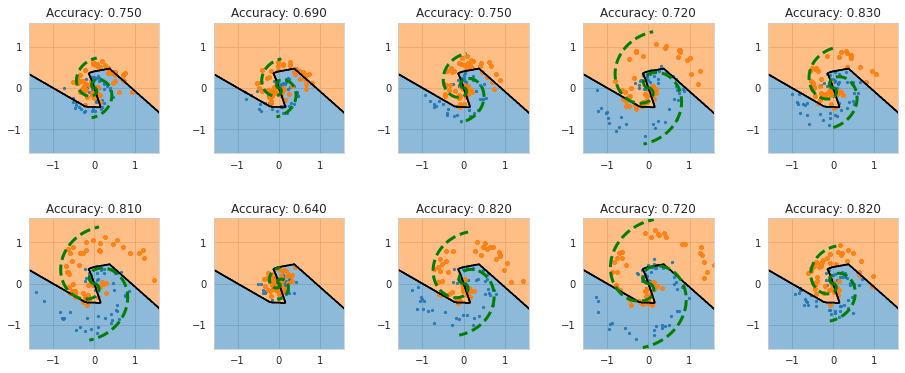

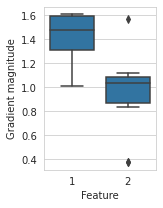

In [8]:
dictCompile = {'loss':tf.keras.losses.BinaryCrossentropy(),
                'metrics': tf.keras.metrics.BinaryAccuracy('acc'),
                'optimizer': tf.keras.optimizers.Adam(lr=0.001)}
dfResultsBase, dfGradsBase, figDBBase = cross_validate(BaseMLP, compile_args=dictCompile)
figDBBase.savefig(os.path.join(strOutputDir, 'conventional_decision_boundaries.png'))
figDBBase.savefig(os.path.join(strOutputDir, 'conventional_decision_boundaries.svg'))
figDBBase.show()

figGradsBase, axGradsBase = plt.subplots(figsize=(arrX.shape[1], 3))
sns.boxplot(data=dfGradsBase, x='Feature', y='Gradient', ax=axGradsBase, color='C0')
axGradsBase.set_ylabel('Gradient magnitude')
figGradsBase.savefig(os.path.join(strOutputDir, 'conventional_feature_gradients.png'))
figGradsBase.savefig(os.path.join(strOutputDir, 'conventional_feature_gradients.svg'))
figGradsBase.show()

compute_95ci(dfResultsBase)

## Meta-learning domain generalization

Mean
Accuracy         0.629929
Test Accuracy    0.632800
dtype: float64
95CI low
Accuracy         0.613166
Test Accuracy    0.614172
dtype: float64
95CI high
Accuracy         0.646692
Test Accuracy    0.651428
dtype: float64


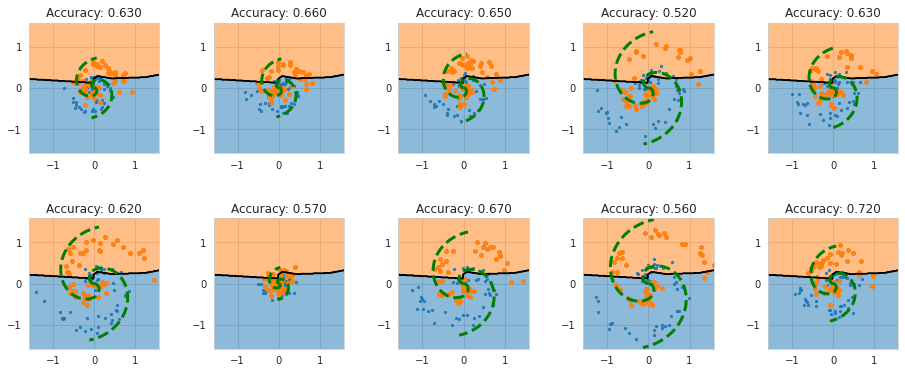

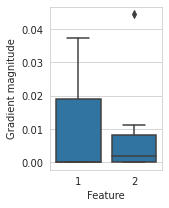

In [9]:
dictCompile = {'loss':tf.keras.losses.BinaryCrossentropy(),
                'metrics': tf.keras.metrics.BinaryAccuracy('acc'),
                'optimizer': tf.keras.optimizers.Adam(lr=0.001)}
dfResultsMLDG, dfGradsMLDG, figDBMLDG = cross_validate(BaseMLP, compile_args=dictCompile, use_mldg=True)
figDBMLDG.savefig(os.path.join(strOutputDir, 'metalearning_decision_boundaries.png'))
figDBMLDG.savefig(os.path.join(strOutputDir, 'metalearning_decision_boundaries.svg'))
figDBMLDG.show()

figGradsMLDG, axGradsMLDG = plt.subplots(figsize=(arrX.shape[1], 3))
sns.boxplot(data=dfGradsMLDG, x='Feature', y='Gradient', ax=axGradsMLDG, color='C0')
axGradsMLDG.set_ylabel('Gradient magnitude')
figGradsMLDG.savefig(os.path.join(strOutputDir, 'metalearning_feature_gradients.png'))
figGradsMLDG.savefig(os.path.join(strOutputDir, 'metalearning_feature_gradients.svg'))
figGradsMLDG.show()

compute_95ci(dfResultsMLDG)

## Conventional MLP with additional cluster membership input

The data X and cluster membership matrix Z are simply concatenated together.

Mean
Accuracy         0.676622
Test Accuracy    0.675500
dtype: float64
95CI low
Accuracy         0.662681
Test Accuracy    0.658177
dtype: float64
95CI high
Accuracy         0.690564
Test Accuracy    0.692823
dtype: float64


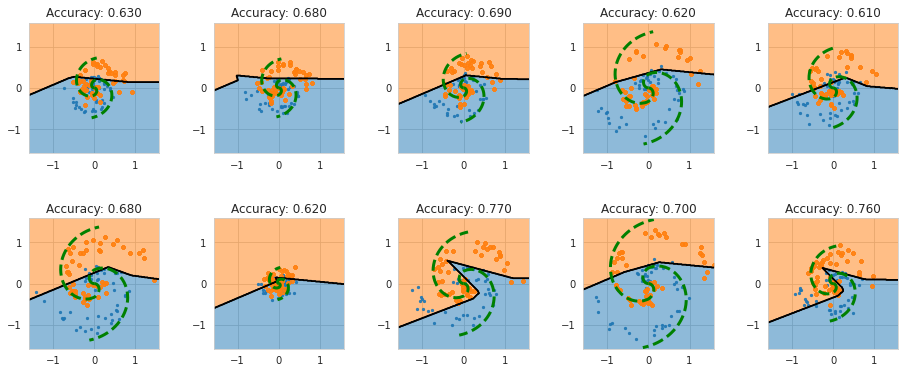

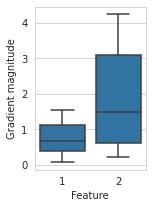

In [10]:
dictCompile = {'loss':tf.keras.losses.BinaryCrossentropy(),
                'metrics': tf.keras.metrics.BinaryAccuracy('acc'),
                'optimizer': tf.keras.optimizers.Adam(lr=0.001)}
dfResultsConcat, dfGradsConcat, figDBConcat = cross_validate(ClusterCovariateMLP, use_z=True, compile_args=dictCompile)
figDBConcat.savefig(os.path.join(strOutputDir, 'concatcluster_decision_boundaries.png'))
figDBConcat.savefig(os.path.join(strOutputDir, 'concatcluster_decision_boundaries.svg'))
figDBConcat.show()

figGradsConcat, axGradsConcat = plt.subplots(figsize=(arrX.shape[1], 3))
sns.boxplot(data=dfGradsConcat, x='Feature', y='Gradient', ax=axGradsConcat, color='C0')
axGradsConcat.set_ylabel('Gradient magnitude')
figGradsConcat.savefig(os.path.join(strOutputDir, 'concatcluster_feature_gradients.png'))
figGradsConcat.savefig(os.path.join(strOutputDir, 'concatcluster_feature_gradients.svg'))
figGradsConcat.show()

compute_95ci(dfResultsConcat)

## Domain adversarial MLP

Mean
Accuracy         0.747662
Test Accuracy    0.752539
dtype: float64
95CI low
Accuracy         0.720332
Test Accuracy    0.724828
dtype: float64
95CI high
Accuracy         0.774991
Test Accuracy    0.780250
dtype: float64


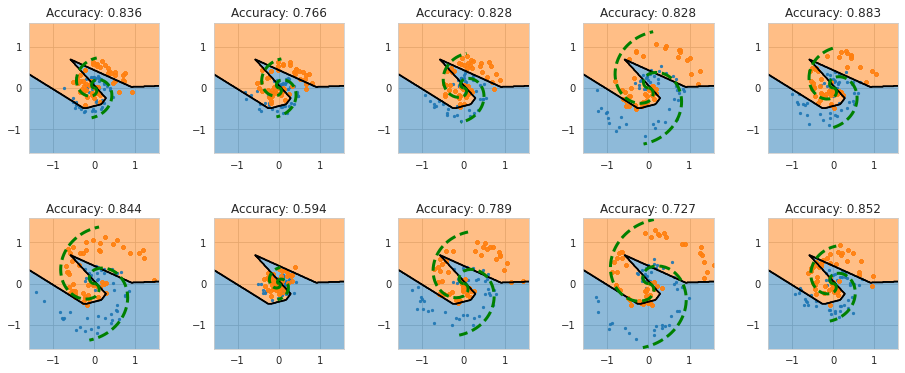

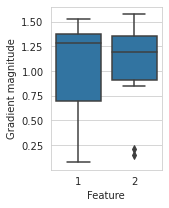

In [11]:
dictBuild = {'n_clusters': dictSpiralParams['clusters'], 'adversary_layer_units': [4, 4]}
dictCompile = {'loss_gen_weight': 0.5,
               'metric_class': tf.keras.metrics.BinaryAccuracy('acc'),
               'metric_adv': tf.keras.metrics.CategoricalAccuracy('adv_acc')}
dfResultsDA, dfGradsDA, figDBDA = cross_validate(DomainAdversarialMLP, use_z=True, 
                                                 build_args=dictBuild, compile_args=dictCompile)
figDBDA.savefig(os.path.join(strOutputDir, 'adversarial_decision_boundaries.png'))
figDBDA.savefig(os.path.join(strOutputDir, 'adversarial_decision_boundaries.svg'))
figDBDA.show()

figGradsDA, axGradsDA = plt.subplots(figsize=(arrX.shape[1], 3))
sns.boxplot(data=dfGradsDA, x='Feature', y='Gradient', ax=axGradsDA, color='C0')
axGradsDA.set_ylabel('Gradient magnitude')
figGradsDA.savefig(os.path.join(strOutputDir, 'adversarial_feature_gradients.png'))
figGradsDA.savefig(os.path.join(strOutputDir, 'adversarial_feature_gradients.svg'))
figGradsDA.show()

compute_95ci(dfResultsDA)

## Mixed effects MLP 
With nonlinear slope layer

2022-02-01 12:51:10.233630: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Mean
Accuracy         0.785816
Test Accuracy    0.787793
dtype: float64
95CI low
Accuracy         0.779762
Test Accuracy    0.779672
dtype: float64
95CI high
Accuracy         0.791869
Test Accuracy    0.795914
dtype: float64


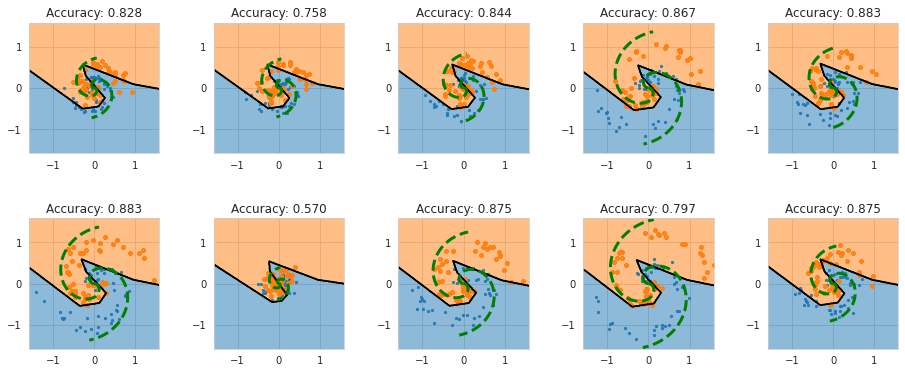

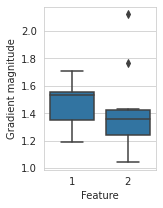

In [12]:
dictBuild = {'n_features': arrX.shape[1],
             'n_clusters': dictSpiralParams['clusters'],
             'adversary_layer_units': [4, 4],
             'slope_posterior_init_scale': 0.3, 
             'intercept_posterior_init_scale': 0.1, 
             'slope_prior_scale': 0.3, 
             'intercept_prior_scale': 0.1,
             'kl_weight': 0.00001}
dictCompile = {'loss_class_fe_weight': 1.0, 
               'loss_gen_weight': 0.5, 
               'loss_class_me_weight': 1.0,
               'metric_class_me': tf.keras.metrics.BinaryAccuracy('acc'),
               'metric_class_fe': tf.keras.metrics.BinaryAccuracy('acc_fe'),
               'metric_adv': tf.keras.metrics.CategoricalAccuracy('adv_acc')}
dfResultsME, dfGradsME, dfRandomSlopeSD, dfRandomIntercept, figDBME = cross_validate(MixedEffectsMLPNonlinearSlope,  
                                                                            use_z=True, 
                                                                            build_args=dictBuild, 
                                                                            compile_args=dictCompile)
figDBME.savefig(os.path.join(strOutputDir, 'mixedeffects_decision_boundaries.png'))
figDBME.savefig(os.path.join(strOutputDir, 'mixedeffects_decision_boundaries.svg'))
figDBME.show()

figGradsME, axGradsME = plt.subplots(figsize=(arrX.shape[1], 3))
sns.boxplot(data=dfGradsME, x='Feature', y='Gradient', ax=axGradsME, color='C0')
axGradsME.set_ylabel('Gradient magnitude')
figGradsME.savefig(os.path.join(strOutputDir, 'mixedeffects_feature_gradients.png'))
figGradsME.savefig(os.path.join(strOutputDir, 'mixedeffects_feature_gradients.svg'))
figGradsME.show()

compute_95ci(dfResultsME)

## Mixed effects MLP

With domain adversarial loss disabled.

Mean
Accuracy         0.793528
Test Accuracy    0.793262
dtype: float64
95CI low
Accuracy         0.771184
Test Accuracy    0.768500
dtype: float64
95CI high
Accuracy         0.815872
Test Accuracy    0.818023
dtype: float64


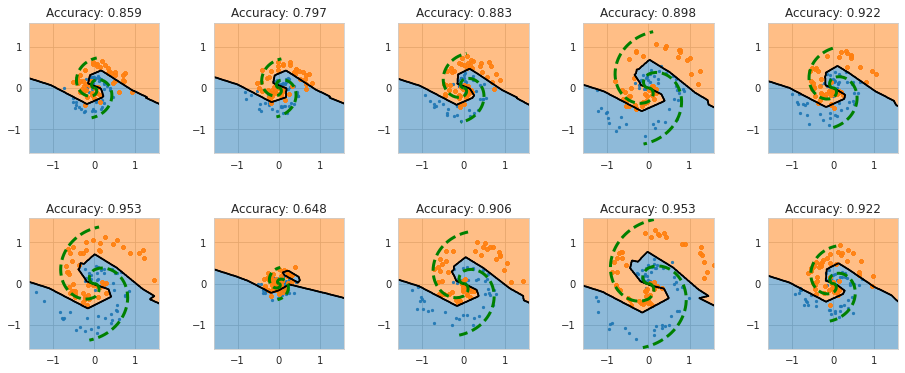

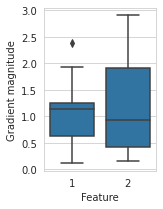

In [13]:
dictBuild = {'n_features': arrX.shape[1],
             'n_clusters': dictSpiralParams['clusters'],
             'adversary_layer_units': [4, 4],
             'slope_posterior_init_scale': 0.3, 
             'intercept_posterior_init_scale': 0.1, 
             'slope_prior_scale': 0.3, 
             'intercept_prior_scale': 0.1,
             'kl_weight': 0.00001}
dictCompile = {'loss_class_fe_weight': 0., 
               'loss_gen_weight': 0., 
               'loss_class_me_weight': 1.0,
               'metric_class_me': tf.keras.metrics.BinaryAccuracy('acc'),
               'metric_class_fe': tf.keras.metrics.BinaryAccuracy('acc_fe'),
               'metric_adv': tf.keras.metrics.CategoricalAccuracy('adv_acc')}
dfResultsME2, dfGradsME2, dfRandomSlopeSD2, dfRandomIntercept2, figDBME2 = cross_validate(MixedEffectsMLPNonlinearSlope,  
                                                                            use_z=True, 
                                                                            build_args=dictBuild, 
                                                                            compile_args=dictCompile)
figDBME2.savefig(os.path.join(strOutputDir, 'mixedeffects_noadv_decision_boundaries.png'))
figDBME2.savefig(os.path.join(strOutputDir, 'mixedeffects_noadv_decision_boundaries.svg'))
figDBME2.show()

figGradsME2, axGradsME2 = plt.subplots(figsize=(arrX.shape[1], 3))
sns.boxplot(data=dfGradsME2, x='Feature', y='Gradient', ax=axGradsME2, color='C0')
axGradsME2.set_ylabel('Gradient magnitude')
figGradsME2.savefig(os.path.join(strOutputDir, 'mixedeffects_noadv_feature_gradients.png'))
figGradsME2.savefig(os.path.join(strOutputDir, 'mixedeffects_noadv_feature_gradients.svg'))
figGradsME2.show()

compute_95ci(dfResultsME2)

## Mixed effects MLP

With Z input randomized to ablate learned RE information.

2022-02-04 12:43:57.401426: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-02-04 12:44:00.006965: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Mean
Accuracy         0.785816
Test Accuracy    0.766992
dtype: float64
95CI low
Accuracy         0.779762
Test Accuracy    0.756388
dtype: float64
95CI high
Accuracy         0.791869
Test Accuracy    0.777596
dtype: float64


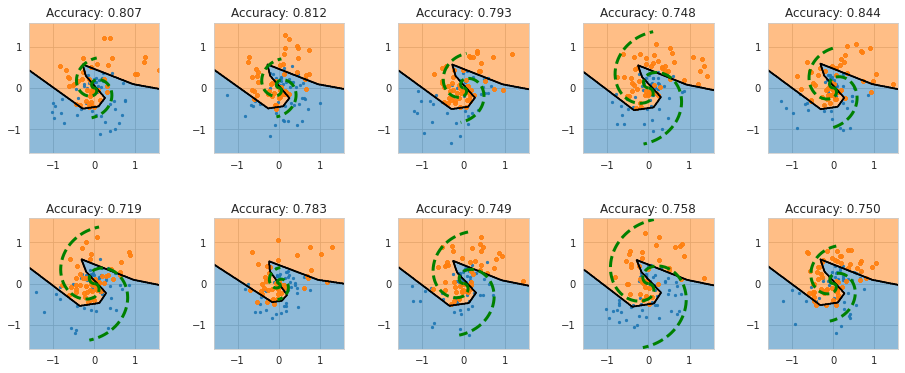

In [8]:
dictBuild = {'n_features': arrX.shape[1],
             'n_clusters': dictSpiralParams['clusters'],
             'adversary_layer_units': [4, 4],
             'slope_posterior_init_scale': 0.3, 
             'intercept_posterior_init_scale': 0.1, 
             'slope_prior_scale': 0.3, 
             'intercept_prior_scale': 0.1,
             'kl_weight': 0.00001}
dictCompile = {'loss_class_fe_weight': 1.0, 
               'loss_gen_weight': 0.5, 
               'loss_class_me_weight': 1.0,
               'metric_class_me': tf.keras.metrics.BinaryAccuracy('acc'),
               'metric_class_fe': tf.keras.metrics.BinaryAccuracy('acc_fe'),
               'metric_adv': tf.keras.metrics.CategoricalAccuracy('adv_acc')}
dfResultsMERandomizedZ, dfGradsMERandomizedZ, dfRandomSlopeSD, dfRandomIntercept, figDBMERandomizedZ = cross_validate(MixedEffectsMLPNonlinearSlope,  
                                                                            use_z=True, 
                                                                            build_args=dictBuild, 
                                                                            compile_args=dictCompile,
                                                                            randomize_z=True)
figDBMERandomizedZ.show()

compute_95ci(dfResultsMERandomizedZ)

Create barplot comparing performance

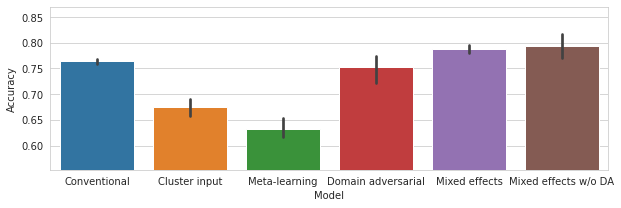

In [14]:
lsPerformance = []
for strModel, df in {'Conventional': dfResultsBase,
                     'Cluster input': dfResultsConcat,
                     'Meta-learning': dfResultsMLDG,
                     'Domain adversarial': dfResultsDA,
                     'Mixed effects': dfResultsME,
                     'Mixed effects w/o DA': dfResultsME2}.items():
    dfLong = df['Test Accuracy'].to_frame('Accuracy')
    dfLong['Model'] = strModel
    lsPerformance += [dfLong]
    
dfPerformance = pd.concat(lsPerformance, axis=0)
figPerf, axPerf = plt.subplots(figsize=(10, 3))
sns.barplot(data=dfPerformance, x='Model',  y='Accuracy', ax=axPerf)
axPerf.set_ylim(dfPerformance['Accuracy'].min() - 0.05, dfPerformance['Accuracy'].max())

figPerf.savefig(os.path.join(strOutputDir, 'performance_comparison.png'))
figPerf.savefig(os.path.join(strOutputDir, 'performance_comparison.svg'))
figPerf.show()

dfPerformance.to_csv(os.path.join(strOutputDir, 'test_performance.csv'))

For the ME-MLP, compare each cluster's learned random intercept with its class balance. When simulating a confounding effect, these two measurements should be highly correlated.

/project/bioinformatics/DLLab/shared/CondaEnvironments/Kevin385Ray/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


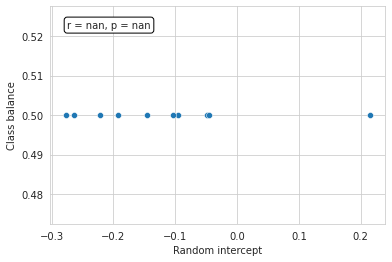

In [15]:
# Compute conversion % by site
dfRatio = pd.DataFrame({'Cluster': arrZ.argmax(axis=1), 'Class': arrY})
dfClusterRatio = dfRatio.groupby('Cluster').mean()
dfClusterRatio.columns = ['Class balance']

dfClusterInt = dfClusterRatio.join(dfRandomIntercept.groupby('Cluster').median())
fig, ax = plt.subplots()
sns.scatterplot(data=dfClusterInt, x='Random intercept', y='Class balance', ax=ax)
r, p = stats.pearsonr(dfClusterInt['Random intercept'], dfClusterInt['Class balance'])
ax.text(0.05, 0.9, f'r = {r:.03f}, p = {p:.2e}', 
        transform=ax.transAxes, bbox={'boxstyle': 'round', 'facecolor': 'white', 'edgecolor': 'k'})

fig.savefig(os.path.join(strOutputDir, 'mixedeffects_random_intercepts.png'))
fig.savefig(os.path.join(strOutputDir, 'mixedeffects_random_intercepts.svg'))

Compare feature importance.

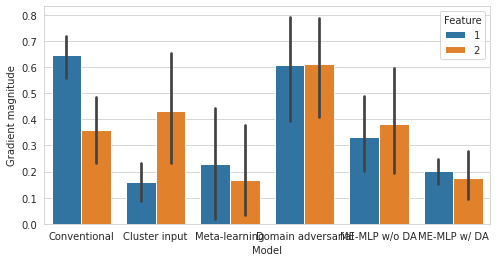

In [16]:
dfGradsBaseNorm = dfGradsBase.copy()
dfGradsBaseNorm['Gradient'] /= dfGradsBaseNorm['Gradient'].max()
dfGradsBaseNorm['Gradient'] -= dfGradsBaseNorm['Gradient'].min()
dfGradsBaseNorm['Model'] = 'Conventional'

dfGradsConcatNorm = dfGradsConcat.copy()
dfGradsConcatNorm['Gradient'] /= dfGradsConcatNorm['Gradient'].max()
dfGradsConcatNorm['Gradient'] -= dfGradsConcatNorm['Gradient'].min()
dfGradsConcatNorm['Model'] = 'Cluster input'

dfGradsMLDGNorm = dfGradsMLDG.copy()
dfGradsMLDGNorm['Gradient'] /= dfGradsMLDGNorm['Gradient'].max()
dfGradsMLDGNorm['Gradient'] -= dfGradsMLDGNorm['Gradient'].min()
dfGradsMLDGNorm['Model'] = 'Meta-learning'

dfGradsDANorm = dfGradsDA.copy()
dfGradsDANorm['Gradient'] /= dfGradsDANorm['Gradient'].max()
dfGradsDANorm['Gradient'] -= dfGradsDANorm['Gradient'].min()
dfGradsDANorm['Model'] = 'Domain adversarial'

dfGradsMENorm = dfGradsME.copy()
dfGradsMENorm['Gradient'] /= dfGradsMENorm['Gradient'].max()
dfGradsMENorm['Gradient'] -= dfGradsMENorm['Gradient'].min()
dfGradsMENorm['Model'] = 'ME-MLP w/ DA'

dfGradsME2Norm = dfGradsME2.copy()
dfGradsME2Norm['Gradient'] /= dfGradsME2Norm['Gradient'].max()
dfGradsME2Norm['Gradient'] -= dfGradsME2Norm['Gradient'].min()
dfGradsME2Norm['Model'] = 'ME-MLP w/o DA'

dfGradsAll = pd.concat([dfGradsBaseNorm, dfGradsConcatNorm, dfGradsMLDGNorm, dfGradsDANorm, dfGradsME2Norm, dfGradsMENorm], axis=0)
figGradsAll, axGradsAll = plt.subplots(figsize=(4 * arrX.shape[1], 4))
sns.barplot(data=dfGradsAll, x='Model', y='Gradient', hue='Feature', ax=axGradsAll)
axGradsAll.set_ylabel('Gradient magnitude')

figGradsAll.savefig(os.path.join(strOutputDir, 'feature_gradients_compared.png'))
figGradsAll.savefig(os.path.join(strOutputDir, 'feature_gradients_compared.svg'))
figGradsAll.show()


When simulating confounds: Test for difference in gradient magnitude between the least important "real" feature and each probe feature

In [17]:
if dictSpiralParams['confounded_vars'] > 0:
    for strModel, df in [('Conventional', dfGradsBase), ('Cluster input', dfGradsConcat), 
                        ('Meta-learning', dfGradsMLDG), ('Domain adversarial', dfGradsDA),
                        ('ME-MLP w/ DA', dfGradsME),
                        ('ME-MLP w/o DA', dfGradsME2)]:
        print(strModel)
        dfRealFeatures = df.loc[df['Feature'].isin(['1', '2'])]
        strRefFeature = dfRealFeatures.groupby('Feature').mean().idxmin().values[0]
        
        for iProbe in range(dictSpiralParams['confounded_vars']):    
            t, p = stats.ttest_rel(df.loc[df['Feature'] == strRefFeature, 'Gradient'],
                                df.loc[df['Feature'] == f'Probe {iProbe + 1}', 'Gradient'])
            print(f'Feature {strRefFeature} vs. Probe {iProbe + 1}: t = {t:.03f}, p = {p:.05f}')